In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from imblearn.over_sampling import SMOTE

In [ ]:
# Load the dataset
df = pd.read_csv('/content/creditcard.csv')

# Display the first few rows of the dataset
print(df.head())

# Display basic information about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Statistical summary of the dataset
print(df.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:
# Filling missing values with column mean
df.fillna(df.mean(), inplace=True)

In [ ]:
# Scaling 'Amount' and 'Time' features
scaler = StandardScaler()

df['Scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Dropping the original 'Amount' and 'Time' columns
df.drop(['Amount', 'Time'], axis=1, inplace=True)

In [ ]:
# Reordering columns
scaled_features = ['Scaled_Amount', 'Scaled_Time']
other_features = [col for col in df.columns if col not in ['Scaled_Amount', 'Scaled_Time', 'Class']]
df = df[scaled_features + other_features + ['Class']]

In [ ]:
# Convert the 'Class' column to integer type
df['Class'] = df['Class'].astype(int)

In [ ]:
from imblearn.over_sampling import SMOTE

# Separating the target variable and features
X = df.drop('Class', axis=1)
y = df['Class']

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original dataset shape:", y.value_counts())
print("Resampled dataset shape:", y_resampled.value_counts())

Original dataset shape: Class
0    13898
1       56
Name: count, dtype: int64
Resampled dataset shape: Class
0    13898
1    13898
Name: count, dtype: int64


In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (22236, 30) (22236,)
Testing set shape: (5560, 30) (5560,)


In [ ]:
# Reshaping data for LSTM
X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

print("Reshaped training set shape:", X_train.shape)
print("Reshaped testing set shape:", X_test.shape)

Reshaped training set shape: (22236, 1, 30)
Reshaped testing set shape: (5560, 1, 30)


In [ ]:
# Importing necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Defining the model
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Displaying the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 32)             8064      
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 11217 (43.82 KB)
Trainable params: 11217 (43.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/20
278/278 - 8s - loss: 0.2295 - accuracy: 0.9603 - val_loss: 0.0367 - val_accuracy: 0.9962 - 8s/epoch - 28ms/step
Epoch 2/20
278/278 - 1s - loss: 0.0264 - accuracy: 0.9966 - val_loss: 0.0111 - val_accuracy: 0.9982 - 1s/epoch - 4ms/step
Epoch 3/20
278/278 - 1s - loss: 0.0142 - accuracy: 0.9982 - val_loss: 0.0065 - val_accuracy: 0.9987 - 1s/epoch - 5ms/step
Epoch 4/20
278/278 - 2s - loss: 0.0106 - accuracy: 0.9986 - val_loss: 0.0048 - val_accuracy: 0.9991 - 2s/epoch - 8ms/step
Epoch 5/20
278/278 - 3s - loss: 0.0082 - accuracy: 0.9986 - val_loss: 0.0031 - val_accuracy: 0.9998 - 3s/epoch - 9ms/step
Epoch 6/20
278/278 - 2s - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.0022 - val_accuracy: 0.9993 - 2s/epoch - 7ms/step
Epoch 7/20
278/278 - 2s - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.0019 - val_accuracy: 0.9996 - 2s/epoch - 8ms/step
Epoch 8/20
278/278 - 2s - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0013 - val_accuracy: 0.9996 - 2s/epoch - 6ms/step
Epoch 9/20
278/278 - 2s

In [ ]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Predicting on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Importing required metrics
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

174/174 [==============================] - 0s 2ms/step - loss: 2.6458e-04 - accuracy: 1.0000
Test Accuracy: 1.0000
174/174 [==============================] - 1s 2ms/step
Confusion Matrix:
[[2779    0]
 [   0 2781]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2779
           1       1.00      1.00      1.00      2781

    accuracy                           1.00      5560
   macro avg       1.00      1.00      1.00      5560
weighted avg       1.00      1.00      1.00      5560



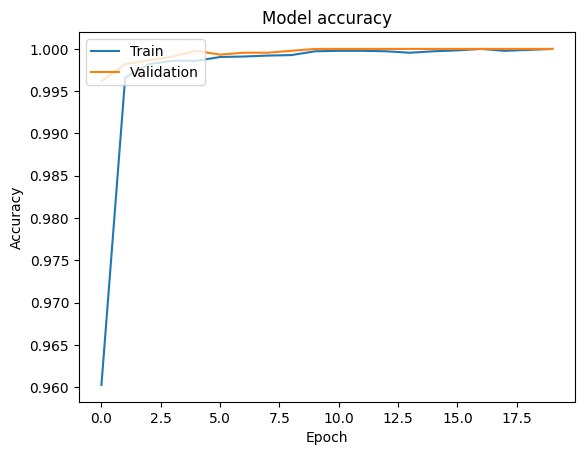

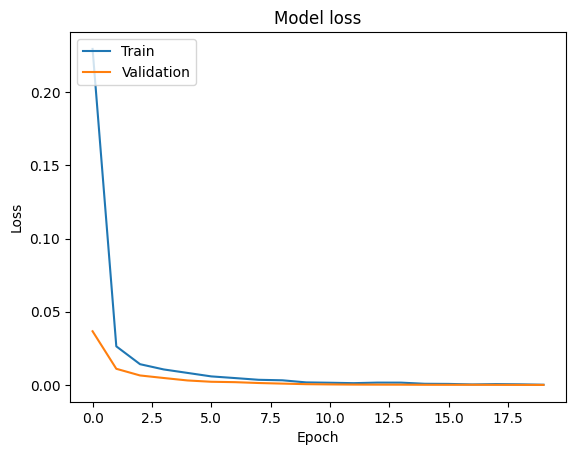

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

Confusion Matrix:
[[2779    0]
 [   0 2781]]


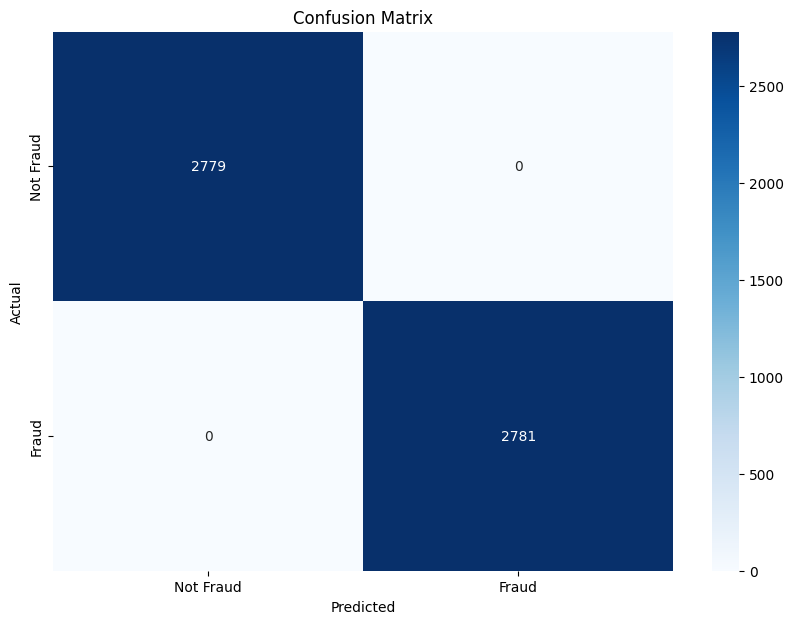

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

RNN

   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

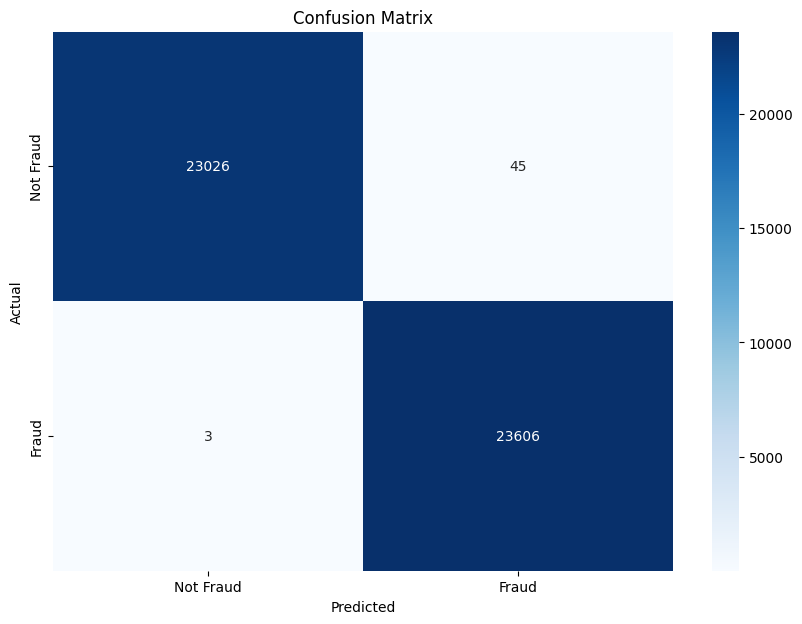

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23071
           1       1.00      1.00      1.00     23609

    accuracy                           1.00     46680
   macro avg       1.00      1.00      1.00     46680
weighted avg       1.00      1.00      1.00     46680



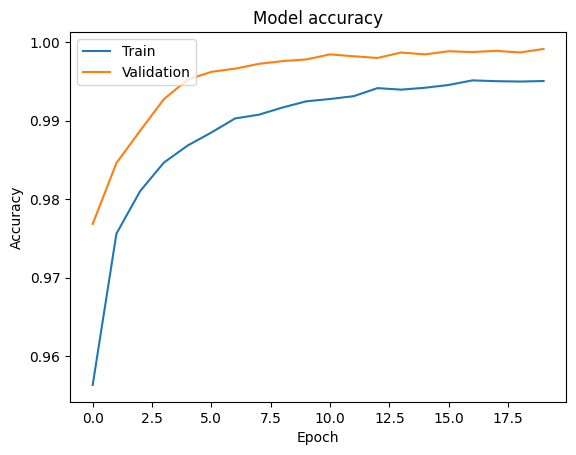

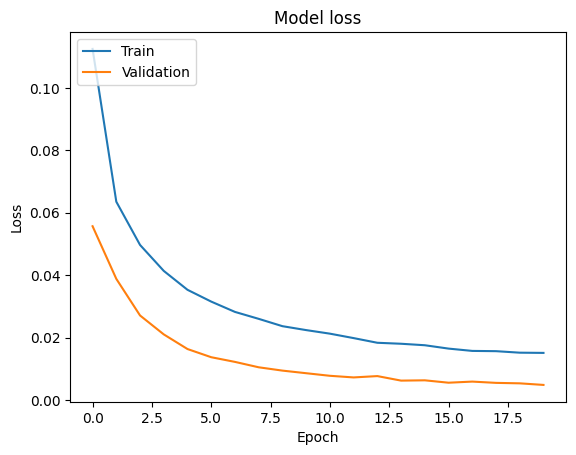

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv('/content/creditcard.csv')

# Display the first few rows of the dataset
print(df.head())

# Display basic information about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Statistical summary of the dataset
print(df.describe())

# Filling missing values with column mean
df.fillna(df.mean(), inplace=True)

# Scaling 'Amount' and 'Time' features
scaler = StandardScaler()

df['Scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Dropping the original 'Amount' and 'Time' columns
df.drop(['Amount', 'Time'], axis=1, inplace=True)

# Reordering columns
scaled_features = ['Scaled_Amount', 'Scaled_Time']
other_features = [col for col in df.columns if col not in ['Scaled_Amount', 'Scaled_Time', 'Class']]
df = df[scaled_features + other_features + ['Class']]

# Convert the 'Class' column to integer type
df['Class'] = df['Class'].astype(int)

# Separating the target variable and features
X = df.drop('Class', axis=1)
y = df['Class']

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original dataset shape:", y.value_counts())
print("Resampled dataset shape:", y_resampled.value_counts())

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Reshaping data for RNN
X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

print("Reshaped training set shape:", X_train.shape)
print("Reshaped testing set shape:", X_test.shape)

# Defining the model
model = Sequential()
model.add(SimpleRNN(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(16, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Displaying the model summary
model.summary()

# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Predicting on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()